In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')



In [2]:
data = pd.read_csv('singapore_airlines_reviews.csv')

In [3]:
data.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [4]:
data.shape

(10000, 7)

In [5]:
data.isna().sum()

published_date        0
published_platform    0
rating                0
type                  0
text                  0
title                 1
helpful_votes         0
dtype: int64

In [6]:
data[data.title.isna()]
# We are using text column to do the sentiment analysis, hence it does not matter that the title column has missing values

,published_date,published_platform,rating,type,text,title,helpful_votes
3918,2019-09-01T04:18:02-04:00,Desktop,2,review,Very rude help desk of Singapore airlines at S...,NaN,1


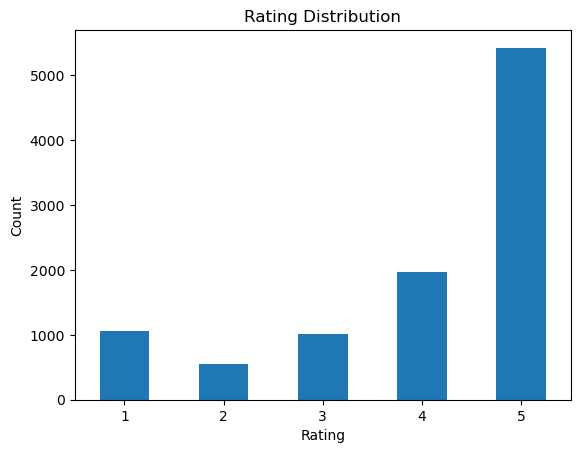

In [7]:
# We can see that a huge majority of the rating scores are very positive
data.rating.value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.show()

In [8]:
# To perform sentiment analysis, we will convert the ratings to binary values. Ratings greater than or equal to 3 will be considered positive and ratings less than 3 will be considered negative.
data.rating = data.rating.apply(lambda x: 1 if x > 3 else 0)

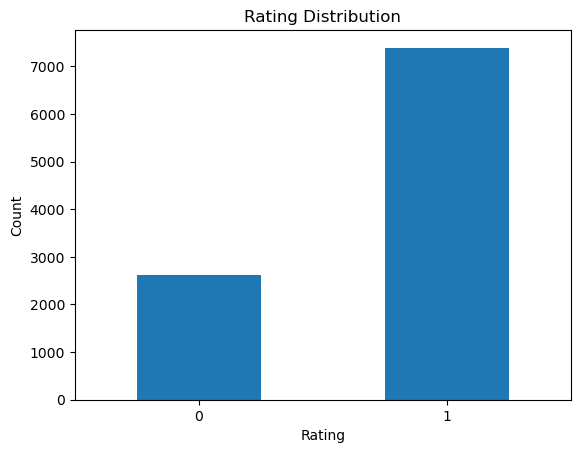

In [9]:
# Even if the positive rating outweighs the negative rating, the difference is not that significant and the tree based machine learning models are robust enough to handle imbalance dataset
data.rating.value_counts().sort_index().plot(kind = 'bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation = 0)
plt.show()

In [10]:
# We will now preprocess the text data by removing special characters, converting the text to lowercase, removing stopwords and lemmatizing the words
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in set(nltk.corpus.stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaenho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Example of the preprocessed text
corpus[0]

'used airline go singapore london heathrow issue ticket cancelled one ticket trying get sorted cost lot money due roaming charge lengthy phone call needed get ticket reinstated trying charge varying amount resolve poor service got airport check desk due issue meant online check done premium economy spacious two seat either side plane seat middle plane seemed relatively new brand new legroom good seat wider bigger arm rest two seat fold away tray table good choice movie thing tv show game etc food ok seem much different economy standard flight crew seemed friendly enough really go isle drink maybe twice whole hour flight airline would done quite often overall flight ok seat comfy legroom good food ok flight crew could attentive especially premium economy would expect service slightly better economy'

In [12]:
# Further breaking down the text into list of words and also remove words that are too short or too long
words=[]
for sent in corpus:
    sent_token=sent_tokenize(sent)
    for sent in sent_token:
        words.append(simple_preprocess(sent))

In [13]:
# We can see that the model has been trained on 10000 sentences and the vector size is 100 (which can include categories such as food, emotions, objects etc.)
# Every word in the model is represented by a 100 dimensional vector, and each element in the vector represents a score for a particular category
# Word2Vec is a shallow neural network model that is trained to reconstruct linguistic contexts of words, which is more efficient than the traditional bag of words or TF-IDF models because it effectively captures the semantics of the words
model = Word2Vec(words, vector_size = 100)
model.corpus_count

10000

In [14]:
# The most similar words inside the text data to 'positive' and their similarity scores
model.wv.similar_by_word('positive')

[('exceeded', 0.9330710172653198),
 ('known', 0.9202669262886047),
 ('consistent', 0.9180899858474731),
 ('warmth', 0.9142006635665894),
 ('marvelous', 0.9089996218681335),
 ('general', 0.9089106917381287),
 ('disappoint', 0.9059510231018066),
 ('consistently', 0.9059302806854248),
 ('aspect', 0.9041556119918823),
 ('truly', 0.903952956199646)]

In [15]:
# The most similar words inside the text data to 'negative' and their similarity scores
model.wv.similar_by_word('negative')

[('spoilt', 0.9596102833747864),
 ('bored', 0.9545475840568542),
 ('charter', 0.9518387317657471),
 ('pity', 0.9512887001037598),
 ('suppose', 0.9509395956993103),
 ('cheer', 0.9468818306922913),
 ('bearing', 0.9448028802871704),
 ('mainly', 0.9445182085037231),
 ('alright', 0.9426164031028748),
 ('reflected', 0.9379562735557556)]

In [16]:
# We would like to calculate the average word2vec vector for each review based on the word2vec vectors of the words in the review, so that we can use the average vectors as features for our machine learning models
# Give progress bar while the code is running
def avg_word2vec(doc):
    return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key],axis=0)
X=[]
for i in tqdm(range(len(words))):
    X.append(avg_word2vec(words[i]))

100%|██████████| 10000/10000 [00:02<00:00, 3460.33it/s]


In [17]:
# This is the final independent features, reshaped to transform the average word2vec from column vector to row vector for every review
Y = data.rating
df = pd.DataFrame()
for i in range(len(X)):
    df = pd.concat([df, pd.DataFrame(X[i].reshape(1, -1))])


# Adding the rating column to the df
df['rating'] = Y.values

In [18]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,rating
0,-0.487067,0.141356,0.050345,-0.057823,0.088750,-0.462946,0.481904,0.281241,-0.402548,-0.094609,...,-0.076918,0.087873,0.119435,0.580459,0.285647,-0.118863,-0.080692,0.293077,-0.052831,0
0,-0.624556,0.192120,-0.078235,-0.089636,-0.001758,-0.479990,0.273122,0.412917,-0.588061,-0.022896,...,-0.023929,0.083750,0.188970,0.427596,0.102019,-0.042190,-0.144808,0.411051,0.100738,1
0,-0.724394,0.157883,0.227674,0.132949,0.169388,-0.558796,0.305311,0.236946,-0.257543,0.172899,...,0.062906,0.319250,0.008619,0.616613,0.426594,-0.160715,-0.060423,0.541346,-0.105921,0
0,0.395025,0.518700,-0.425953,0.027032,0.327323,-0.211204,0.268153,0.615816,0.038326,-0.552648,...,0.323297,0.223066,0.005331,0.676665,-0.019389,-0.070938,-0.117321,0.155654,-0.326293,1
0,-0.377446,0.325208,0.081644,-0.089876,0.110738,-0.449643,0.225207,0.206817,-0.184541,-0.019798,...,0.117529,0.138458,-0.032000,0.538796,0.265166,-0.062520,-0.091408,0.338125,-0.240694,0


In [19]:
df.shape

(10000, 101)

In [20]:
# Output feature
y = df['rating']

In [21]:
# Perform train-test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

------------------------------------
LogisticRegression
Accuracy: 0.86
F1 Score: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       521
           1       0.89      0.92      0.91      1479

    accuracy                           0.86      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.86      0.86      0.86      2000



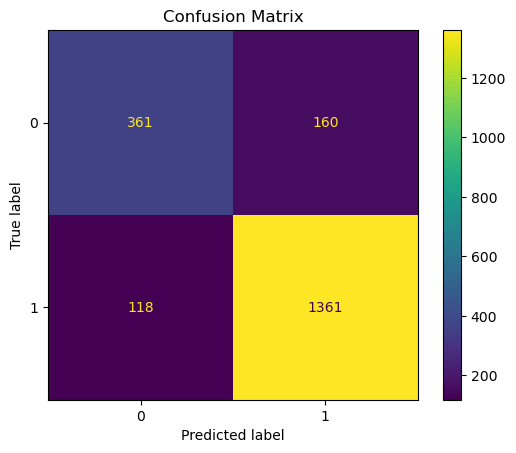

------------------------------------
------------------------------------
NaiveBayes
Accuracy: 0.78
F1 Score: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.84      0.67       521
           1       0.93      0.76      0.84      1479

    accuracy                           0.78      2000
   macro avg       0.74      0.80      0.75      2000
weighted avg       0.83      0.78      0.79      2000



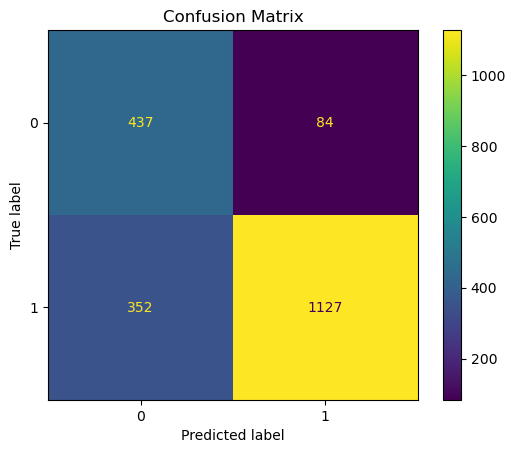

------------------------------------
------------------------------------
DecisionTree
Accuracy: 0.78
F1 Score: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       521
           1       0.86      0.85      0.85      1479

    accuracy                           0.78      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.78      0.78      0.78      2000



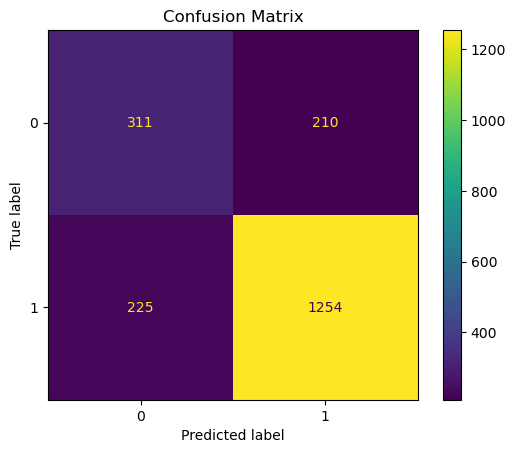

------------------------------------
------------------------------------
SupportVectorMachine
Accuracy: 0.86
F1 Score: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       521
           1       0.89      0.93      0.91      1479

    accuracy                           0.86      2000
   macro avg       0.83      0.80      0.81      2000
weighted avg       0.86      0.86      0.86      2000



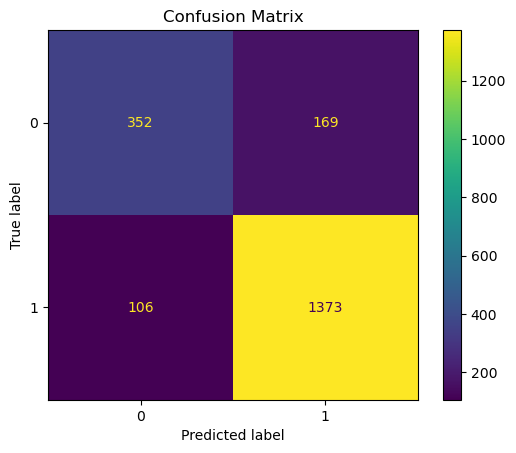

------------------------------------
------------------------------------
RandomForest
Accuracy: 0.85
F1 Score: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       521
           1       0.88      0.93      0.90      1479

    accuracy                           0.85      2000
   macro avg       0.82      0.78      0.80      2000
weighted avg       0.85      0.85      0.85      2000



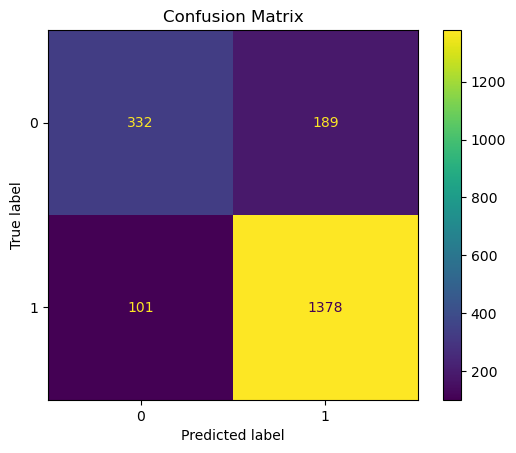

------------------------------------
------------------------------------
AdaBoost
Accuracy: 0.85
F1 Score: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       521
           1       0.88      0.91      0.90      1479

    accuracy                           0.85      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.84      0.85      0.84      2000



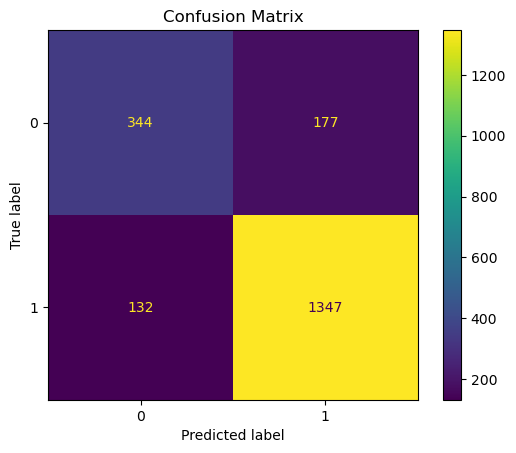

------------------------------------
------------------------------------
GradientBoosting
Accuracy: 0.85
F1 Score: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       521
           1       0.88      0.92      0.90      1479

    accuracy                           0.85      2000
   macro avg       0.81      0.79      0.80      2000
weighted avg       0.85      0.85      0.85      2000



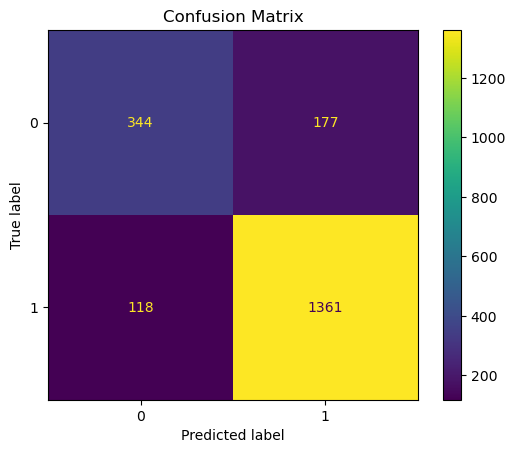

------------------------------------
------------------------------------
XGBoost
Accuracy: 0.86
F1 Score: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       521
           1       0.89      0.92      0.90      1479

    accuracy                           0.86      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.85      0.86      0.85      2000



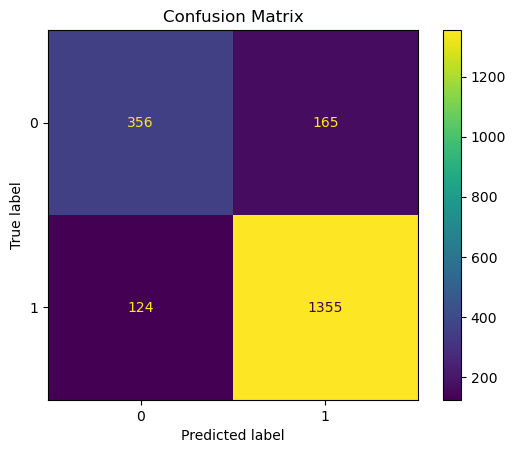

------------------------------------


In [22]:
# Use a variety of classification models (include ensemble techniques) to predict the sentiment of the reviews and evaluate the performance of the models using accuracy, recall and confusion matrix
models = {
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(),
    'SupportVectorMachine': SVC(),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()


}
def model_fit(models):
    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print('------------------------------------')
        print(model_name)
        print(f'Accuracy: {accuracy_score(y_test,y_pred):.2f}')
        print(f'F1 Score: {f1_score(y_test,y_pred):.2f}')
        print('Classification Report:')
        print(classification_report(y_test,y_pred))
        ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
        plt.title("Confusion Matrix")
        plt.show()
        print('------------------------------------')
    
model_fit(models)


In [ ]:
# Both the logistic regression and the support vector machine performed the best in terms of accuracy and f1 score, hence we will use these 2 models for our sentiment analysis.